In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import Artificial_Neural_Networks as ANN
import ARIMA

import math
from itertools import groupby
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from importlib import reload
import itertools
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

## Preprocess data

In [5]:
PATH = 'rainfall_data_1901_to_2002.xlsx'

In [6]:
data = pd.read_excel(PATH)

In [7]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))
data.head()

,State,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Andhra Pradesh,Adilabad,1901,6.725,10.488,23.288,35.560,23.119,115.546,294.119,276.865,181.615,47.310,1.339,0.000
1,Andhra Pradesh,Adilabad,1902,0.420,0.000,0.388,6.070,3.331,45.960,233.973,167.971,198.177,26.447,35.083,11.222
2,Andhra Pradesh,Adilabad,1903,6.643,1.956,0.173,4.551,33.348,132.078,436.611,334.544,226.037,138.818,14.095,8.823
3,Andhra Pradesh,Adilabad,1904,0.054,0.121,11.446,0.017,16.900,131.048,160.694,81.865,251.577,110.391,0.146,0.130
4,Andhra Pradesh,Adilabad,1905,0.589,2.293,8.252,35.020,17.569,79.937,96.331,313.522,361.697,4.950,0.146,0.000


In [8]:
m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')
m_data.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000


In [9]:
districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

In [10]:
maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

#maharashtra_data = maharashtra_data.rename(columns={'Gadchiroli': 'Garhchiroli'})
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


## Correlation matrix - Districts

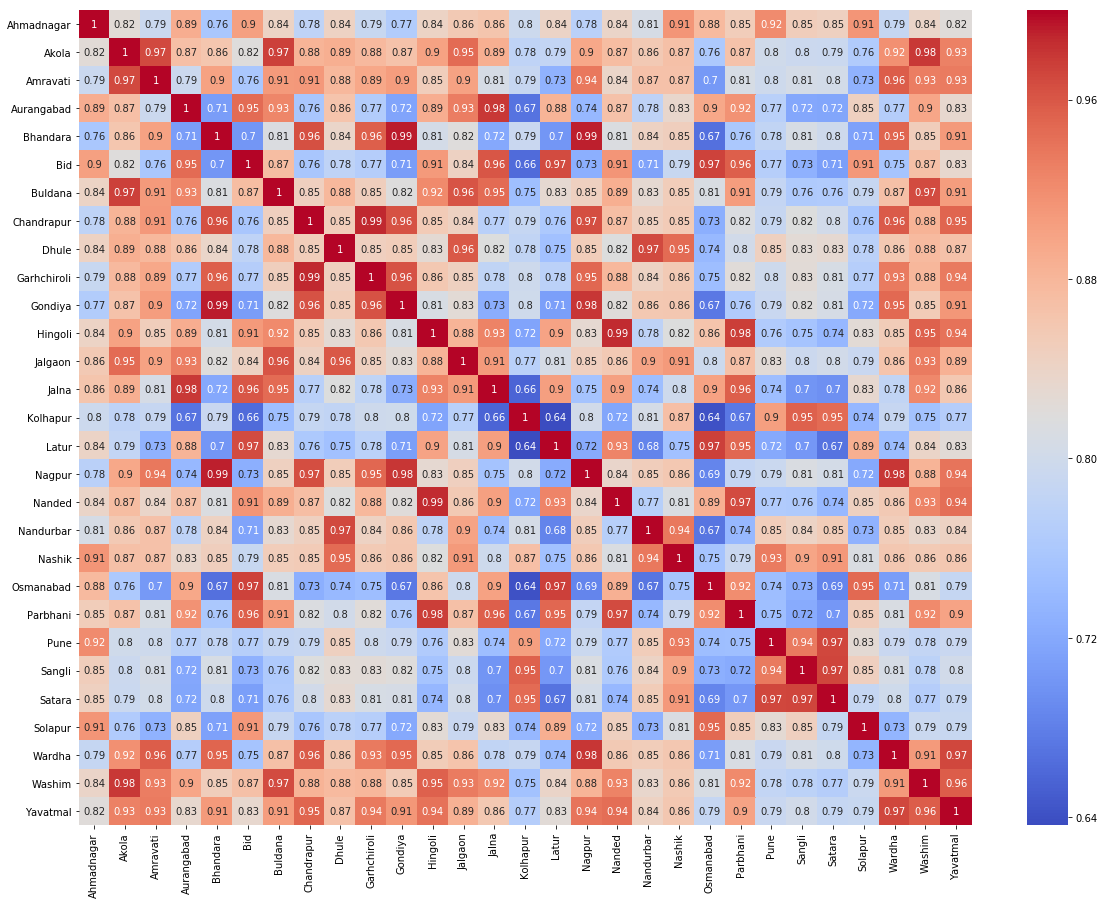

In [11]:
corr_matrix = maharashtra_data.drop(columns=['Year', 'Month']).corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Highly correlated districts

In [12]:
def return_highly_correlated(corr_matrix, corr_coef):
    district_corr = corr_matrix.abs().unstack().sort_values().drop_duplicates()
    tuples = district_corr[(district_corr > corr_coef) & (district_corr != 1.0)]
    levels = tuples.index.levels[0]
    labels = tuples.index.labels

    high_corr_districts = []
    for i in range(len(labels[0])):
        high_corr_districts.append([levels[labels[0][i]], levels[labels[1][i]], tuples[i]])
    high_corr_districts = np.array(high_corr_districts)
    df = pd.DataFrame({'District1': high_corr_districts[:, 0], 
                      'District2': high_corr_districts[:, 1],
                      'Correlation_coefficient': high_corr_districts[:, 2]},
                     columns = ['District1', 'District2', 'Correlation_coefficient'])
    return df

In [13]:
high_corr_districts = return_highly_correlated(corr_matrix, 0.98)
high_corr_districts

,District1,District2,Correlation_coefficient
0,Nagpur,Gondiya,0.9805330709528167
1,Nagpur,Wardha,0.9811563634226902
2,Nanded,Hingoli,0.9858166679818119
3,Chandrapur,Garhchiroli,0.9885737788804028
4,Nagpur,Bhandara,0.9907760645844106
5,Bhandara,Gondiya,0.9922307205938624


### Highly correlated districts - Map

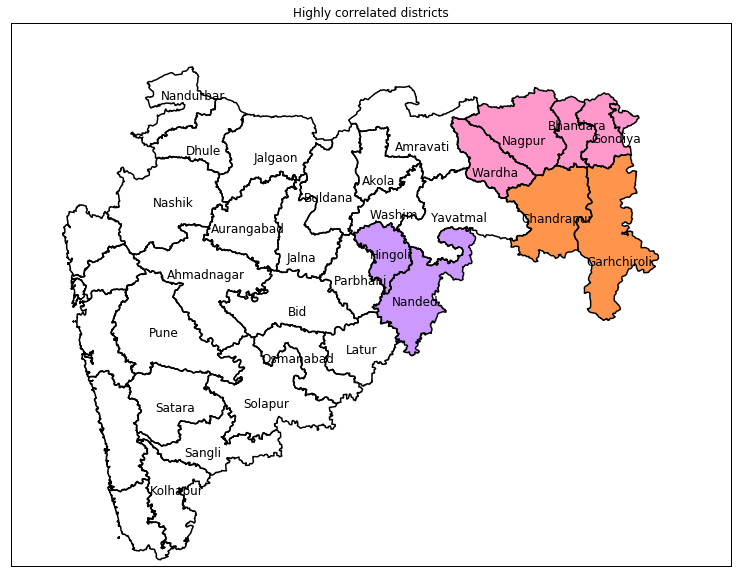

In [14]:
correlated_districts = [['Nagpur', 'Gondiya', 'Wardha', 'Bhandara'], ['Nanded', 'Hingoli'], ['Chandrapur', 'Garhchiroli']]
correlated_districts_dict = {}
bin_num = 0
for l in correlated_districts:
    for dist in l:
        correlated_districts_dict[dist]=bin_num
    bin_num+=1

latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)

num_colors = len(correlated_districts)
cm = plt.get_cmap('rainbow')
correlated_districts_df = pd.DataFrame({'Method': list(correlated_districts_dict.values())})
correlated_districts_df.index = correlated_districts_dict.keys()
correlated_districts_df['bin'] = correlated_districts_dict.values()
scheme = ['#ff99cc', '#cc99ff', '#ff944d']
# scheme = [cm(i / num_colors) for i in range(num_colors)]
values = correlated_districts_df.bin
#bins = np.linspace(values.min(), values.max(), num_colors)

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15.5,urcrnrlon=82,urcrnrlat=22.5,lat_0=16,lon_0=75.11)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []
for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker='', color='black')
        district = info['NAME_2']
        if district not in correlated_districts_df.index:
            color = '#dddddd'
        else:
            color = scheme[correlated_districts_df.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Highly correlated districts")

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    district_name = label_dist[i]
    ax.annotate(district_name, (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black')
plt.show()

### Rainfall for the district "Kolhapur"

Text(0.5,1,'Rainfall of Kolhapur district')

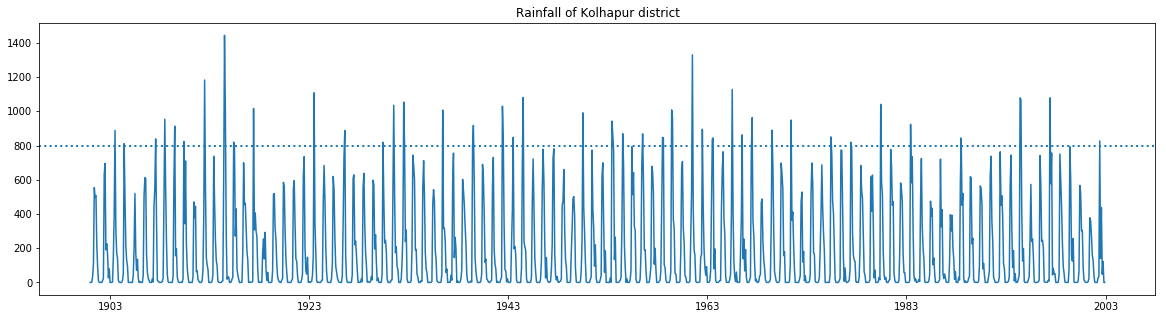

In [15]:
plt.figure(figsize=(20,5))
plt.plot(maharashtra_data.Date, maharashtra_data.Kolhapur)
plt.axhline(y=800, linewidth=2, linestyle='dotted')
plt.title('Rainfall of Kolhapur district')

In [16]:
maharashtra_data[maharashtra_data.Month == 'Jul'].Kolhapur.mean()

676.4755490196079

## Plot the districts with heavy rainfall over all years(>700|800mm)

In [17]:
high_rainfall = {}
high_rainfall_months = {}
districts = maharashtra_data.columns[3:]
for district in districts:
    count = len(maharashtra_data[maharashtra_data[district]>=800])
    if count != 0:
#         print(district)
#         print(maharashtra_data[maharashtra_data[district]>=800].head(40))
        high_rainfall[district] = count
        high_rainfall_months[district] = list(maharashtra_data[maharashtra_data[district]>=800].Month)
        
for district in high_rainfall_months:
    print(district)
    counts = [(i, len(list(c))) for i,c in groupby(sorted(high_rainfall_months[district]))] 
    print(counts)
high_rainfall

Satara
[('Jul', 20), ('Jun', 5)]
Kolhapur
[('Aug', 5), ('Jul', 27), ('Jun', 17)]
Nandurbar
[('Jul', 10)]
Sangli
[('Jul', 1)]
Nashik
[('Jul', 1)]
Pune
[('Jul', 2), ('Jun', 1)]


{'Kolhapur': 49,
 'Nandurbar': 10,
 'Nashik': 1,
 'Pune': 3,
 'Sangli': 1,
 'Satara': 25}

           Count  bin
Satara        25    0
Kolhapur      49    0
Nandurbar     10    0
Sangli         1    0
Nashik         1    0
Pune           3    0


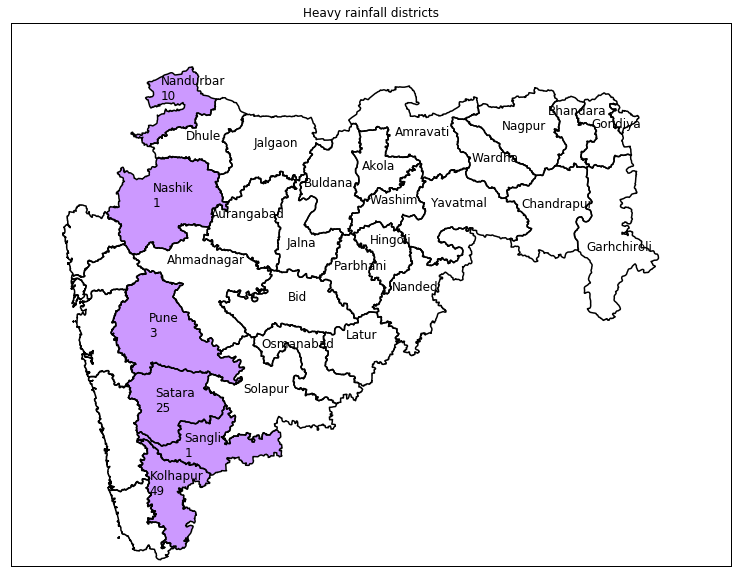

In [27]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)

num_colors = 1
cm = plt.get_cmap('rainbow')
high_rainfall_df = pd.DataFrame({'Count': list(high_rainfall.values())})
high_rainfall_df.index = high_rainfall.keys()
high_rainfall_df['bin'] = 0
#scheme = ['#ff99cc', '#cc99ff', '#ff944d']
scheme = ['#cc99ff']
values = high_rainfall_df.bin
print(high_rainfall_df)

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15.5,urcrnrlon=82,urcrnrlat=22.5,lat_0=16,lon_0=75.11)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []
for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker='', color='black')
        district = info['NAME_2']
        if district not in high_rainfall_df.index:
            color = '#dddddd'
        else:
            color = scheme[high_rainfall_df.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Heavy rainfall districts")

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    district_name = label_dist[i]
    try:
        ax.annotate(district_name + "\n" + str(high_rainfall_df.ix[district_name].Count), (x,y), xytext=(0,0), textcoords='offset points', fontsize=12, color='black')
    except:
        ax.annotate(district_name + "\n", (x,y), xytext=(0,0), textcoords='offset points', fontsize=12, color='black')
plt.show()

## Boxplot - District wise precipitation across all years

In [ ]:
matrix = maharashtra_data.drop(columns=['Date', 'Year', 'Month'])

plt.figure(figsize=(15,10))
g = sns.boxplot(x="variable", y="value", data=pd.melt(matrix))
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_xlabel('District')
g.set_ylabel('Precipitation')
g.set_title('District wise precipitation across all years')
plt.axhline(y=700, linewidth=2, linestyle='dotted')
plt.axhline(y=800, linewidth=2, linestyle='dotted')

- In district 'Kolhapur', the precipitation is above 800mm for many times. It says that the rainfall was heavy in Kolhapur district.

## Yearly average precipitation data across all districts in Maharashtra

In [ ]:
m_data_copy = maharashtra_data.copy()
m_data_copy = m_data_copy.drop(columns=['Date', 'Year', 'Month'])
m_data_copy = m_data_copy.groupby(np.arange(len(df))//12).mean()
columns = m_data_copy.columns
columns = columns.insert(0, 'Year')
m_data_copy['Year'] = maharashtra_data.Year.unique()
m_data_copy = m_data_copy.reindex(columns=columns)
m_data_copy.set_index('Year', inplace=True)

In [ ]:
m_data_copy.head()

## Monthly rainfall for each year in Maharashtra

In [ ]:
m_data_copy = m_data.copy()
m_data_copy['Jan-Feb'] = m_data_copy['Jan'] + m_data_copy['Feb']
m_data_copy['Mar-May'] = m_data_copy['Mar'] + m_data_copy['Apr'] + m_data_copy['May']
m_data_copy['Jun-Sep'] = m_data_copy['Jun'] + m_data_copy['Jul'] + m_data_copy['Aug'] + m_data_copy['Sep']
m_data_copy['Oct-Dec'] = m_data_copy['Oct'] + m_data_copy['Nov'] + m_data_copy['Dec']
m_data_copy['Annual'] = m_data_copy['Jan-Feb'] + m_data_copy['Mar-May'] + m_data_copy['Jun-Sep'] + m_data_copy['Oct-Dec']
m_data_copy.head()

In [ ]:
months = list(m_data.columns[1:])
m_data_copy[months].groupby("Year").sum().plot(figsize=(13,8))

## Seasonal rainfall for each year in Maharashtra

In [ ]:
seasonal_data = m_data_copy[['Year','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("Year").sum()

In [ ]:
seasonal_data.plot(figsize=(13,8))

## District wise Seasonal rainfall across all years

In [ ]:
seasonal_district_data = m_data_copy[['District','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("District").sum()
seasonal_district_data.head()

In [ ]:
seasonal_district_data.plot.barh(stacked=True,figsize=(20,15));

## District wise Monthly mean precipitation across all years

In [ ]:
columns = list(m_data.columns[2:])
columns.insert(0, m_data.columns[0])
monthly_mean_data = m_data_copy[columns].groupby("District").sum()
monthly_mean_data.head()

In [ ]:
monthly_mean_data.plot.barh(stacked=True,figsize=(20,15));

## Annual rainfall in Maharshtra

In [ ]:
Annual_rainfall = m_data_copy.groupby('Year').sum()['Annual']
Annual_rainfall.plot(figsize=(12,8))

## Best method for each district

In [ ]:
maharashtra_data.Ahmadnagar.head()

In [ ]:
dates

In [ ]:
rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[:-60]})
rainfall_data.index = dates[:-60]
rainfall_data.tail()

In [ ]:
test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[-60:]})
test_rainfall_data.index = dates[-60:]
test_rainfall_data.head()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rainfall_data)

### FNN, TLNN, SANN and LSTM

In [ ]:
future_steps = 60
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_FNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_FNN = [[12], [4], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
#parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
#parameters_SANN = [[12], [3], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[6,8,10,11,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_LSTM = [[12], [4], [1], [30], [20], [future_steps]]

In [ ]:
for district in districts:
    print(district)
    
    rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
    rainfall_data.index = dates[:-60]
    
    test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
    test_rainfall_data.index = dates[-60:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(rainfall_data)
    
    output_folder = STORAGE_FOLDER + district + '/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ANN = reload(ANN)
    RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                    parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, output_folder)

    ANN = reload(ANN)
    ANN.save_RMSE_info(output_folder, RMSE_info)

In [ ]:
districts

### Update with ARIMA and find the best method

In [ ]:
for district in districts:
    print(district)
    
    rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
    rainfall_data.index = dates[:-60]
    
    test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
    test_rainfall_data.index = dates[-60:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(rainfall_data)
    
    output_folder = STORAGE_FOLDER + district + '/'
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    ARIMA = reload(ARIMA)
    forecasted_values = ARIMA.ARIMA(rainfall_data, output_folder, future_steps)
    
    errors = test_rainfall_data.Precipitation - forecasted_values
    ARIMA_actual_forecasted = pd.DataFrame({'Actual': test_rainfall_data.Precipitation, 
                                           'Forecasted': forecasted_values,
                                           'Errors': errors})
    ARIMA_actual_forecasted.to_csv(output_folder + '/' + 'ARIMA_actual_and_forecasted.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(ARIMA_actual_forecasted.drop(columns=['Actual', 'Forecasted']), color='blue', label='Error: Actual - Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Error')
    plt.legend(loc='best')
    plt.title('ARIMA - Error: Actual - Forecasted')
    plt.savefig(output_folder + 'ARIMA_error_plot'  + '.png')
    
    y_true = test_rainfall_data.ix[:int(future_steps)]
    plt.figure(figsize=(10,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecasted_values, color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.ylabel('Monthly mean Precipitation')
    plt.legend(loc='best')
    plt.title('ARIMA - Comaprison: Actual vs Forecasted')
    plt.savefig(output_folder + 'ARIMA_best_forecast'  + '.png')
    
    mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values)
    RMSE_score = pd.read_csv(output_folder + 'RMSE_score.csv')
    best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
    RMSE_score = RMSE_score.append({'Unnamed: 0': 'ARIMA', 'RMSE': str(rmse)}, ignore_index=True)
    RMSE_score.RMSE = RMSE_score.RMSE.astype('float')
    
    current_best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
    
    RMSE_score = RMSE_score.set_index('Unnamed: 0')
    RMSE_score.to_csv(output_folder + 'RMSE_score.csv')
    
    axis = RMSE_score.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')
    axis.set_xlabel('Method name')
    for p in axis.patches:
        axis.annotate(np.round(p.get_height(),decimals=2), 
                    (p.get_x()+p.get_width()/2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=14, color='black')
    
    fig = axis.get_figure()
    fig.savefig(output_folder + 'RMSE.png')
    
    if current_best_method == 'ARIMA':
        y_true = test_rainfall_data.ix[:int(future_steps)]
        plt.figure(figsize=(10,5))
        plt.plot(y_true, color='green', label='Actual values')
        plt.plot(forecasted_values, color='red', label='Forecasted values')
        plt.xlabel('Year')
        plt.ylabel('Monthly mean Precipitation')
        plt.legend(loc='best')
        plt.title('Best of all: ARIMA - Comaprison: Actual vs Forecasted')
        plt.savefig(output_folder + 'BEST_FORECAST_ARIMA'  + '.png')
        print('abhi')
        os.remove(output_folder + 'BEST_FORECAST_' + best_method + '.png')

### Put all best forecast prediction files in a folder

In [ ]:
STORAGE_FOLDER = 'State_predictions/'
OUTPUT_FOLDER = 'Best_forecast_predictions/'
if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

for district in districts:
    file = STORAGE_FOLDER + district + '/' + 'RMSE_score.csv'
    rmse_score = pd.read_csv(file)
    method = rmse_score.ix[rmse_score.RMSE.argmin]['Unnamed: 0']
    shutil.copy(STORAGE_FOLDER + district + '/' + 'BEST_FORECAST_' + method + '.png', OUTPUT_FOLDER)
    os.rename(OUTPUT_FOLDER + 'BEST_FORECAST_' + method + '.png',
             OUTPUT_FOLDER + '/' + district + '_' + method + '.png')

### Maharashtra Map - Visualization

In [ ]:
year_precipation = pd.DataFrame({'Precipitation': maharashtra_data.ix[0][3:]})
year_precipation.index = maharashtra_data.ix[0].index[3:]
year_precipation.head()

In [ ]:
num_colors = 9
values = year_precipation['Precipitation'].astype(float)
cm = plt.get_cmap('rainbow')
# rainbow, spring, PuRd, plasma
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
year_precipation.sort_values('bin', ascending=False).head()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
# map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    
#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()

In [ ]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)
latlon_data.shape

In [ ]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
# map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='w')

        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Maharashtra Map")    

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    ax.annotate(label_dist[i], (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black',arrowprops=dict(facecolor='white', shrink=0.1))

#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()

In [ ]:
STORAGE_FOLDER = 'State_predictions/'
district_best_method = {}
for district in districts:
    file = STORAGE_FOLDER + district + '/' + 'RMSE_score.csv'
    rmse_score = pd.read_csv(file)
    method = rmse_score.ix[rmse_score.RMSE.argmin]['Unnamed: 0']
    district_best_method[district] = method

In [ ]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)
latlon_data.shape

In [ ]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)

num_colors = 2
cm = plt.get_cmap('rainbow')
best_method_df = pd.DataFrame({'Method': list(district_best_method.values())})
best_method_df.index = district_best_method.keys()
best_method_df['bin'] = best_method_df.Method.map({'ARIMA': 0, 'LSTM': 1})
scheme = ['#ff99cc', '#cc99ff']

values = best_method_df.bin
bins = np.linspace(values.min(), values.max(), num_colors)



fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

# map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15.5,urcrnrlon=82,urcrnrlat=22.5,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='w')

        district = info['NAME_2']
        if district not in best_method_df.index:
            color = '#dddddd'
        else:
            color = scheme[best_method_df.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("District wise best method")

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    district_name = label_dist[i]
    ax.annotate(district_name + '\n' + district_best_method[district_name], (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black')

patch1 = mpatches.Patch(color=scheme[0], label='ARIMA')
patch2 = mpatches.Patch(color=scheme[1], label='LSTM')
plt.legend(handles=[patch1, patch2])

plt.show()